In [95]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob, os, json, re, ast

### Data
The data for this project comes from the Free Music Archive, an open dataset hosted from this Github repository (https://github.com/mdeff/fma). The fma_medium partition of the dataset was selected, which contains approximately 25,000 songs. In the following cells, the data is preprocessed using pandas and numpy.

In [96]:
songs = glob.glob('fma_md_specs/*')
ids = [(os.path.basename(x).replace('.npy','')).lstrip('0') for x in songs]
ids = np.array(ids)
ids = ids.astype(int)

# need to find genre for each
df_tracks = pd.read_csv('../fma_metadata/raw_tracks.csv')
rel_tracks = df_tracks[df_tracks['track_id'].isin(ids)]
rel_tracks.head()

,track_id,album_id,album_title,album_url,artist_id,artist_name,artist_url,artist_website,license_image_file,license_image_file_large,...,track_information,track_instrumental,track_interest,track_language_code,track_listens,track_lyricist,track_number,track_publisher,track_title,track_url
0,2,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,4656,en,1293,NaN,3,NaN,Food,http://freemusicarchive.org/music/AWOL/AWOL_-_...
1,3,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1470,en,514,NaN,4,NaN,Electric Ave,http://freemusicarchive.org/music/AWOL/AWOL_-_...
2,5,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1933,en,1151,NaN,6,NaN,This World,http://freemusicarchive.org/music/AWOL/AWOL_-_...
3,10,6.0,Constant Hitmaker,http://freemusicarchive.org/music/Kurt_Vile/Co...,6,Kurt Vile,http://freemusicarchive.org/music/Kurt_Vile/,http://kurtvile.com,http://i.creativecommons.org/l/by-nc-nd/3.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,54881,en,50135,NaN,1,NaN,Freeway,http://freemusicarchive.org/music/Kurt_Vile/Co...
9,134,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1126,en,943,NaN,5,NaN,Street Music,http://freemusicarchive.org/music/AWOL/AWOL_-_...


In [97]:
ids_and_genres = rel_tracks[['track_id', 'track_genres']]

In [98]:
ids_and_genres = ids_and_genres.values
ids_and_genres = ids_and_genres.tolist()
ord_ids = []
genres = []
for id,genre_info in ids_and_genres:
    #print(genre_info)
    genre_dict = ast.literal_eval(re.search('({.+})', genre_info).group(0))
    #print(genre_dict)
    ord_ids.append(id)
    try:
        g_id = genre_dict['genre_id']
    except:
        g_id = genre_dict[0]['genre_id']
    genres.append(g_id)
    
data = {'track_id': ord_ids, 'genre_id': genres}
ids_genre_df = pd.DataFrame(data=data)
ids_genre_df.to_csv('ids_genre_df.csv')
ids_genre_df.head()

,genre_id,track_id
0,21,2
1,21,3
2,21,5
3,10,10
4,21,134


In [99]:
def get_embeddings_and_ids(embedding_dir):
    song_embs = []
    songs = glob.glob(embedding_dir + '*')[:5000]
    song_ids = [(os.path.basename(x).replace('.npy','')).lstrip('0') for x in songs]
    song_ids = np.array(song_ids)
    song_ids = song_ids.astype(int)

    for song in songs:
        s = np.load(song)
        song_embs.append(s)

    song_embs = np.array(song_embs)
    
    return song_embs, song_ids

In [100]:
# find genres for avg song d-vec model song embeddings
def ordered_genres_and_ids(ids, ids_genre_df):
    genre_spec_ids = []
    genre_num_ids = np.unique(ids_genre_df['genre_id'].values)
    for genre_type in genre_num_ids:
        genre_tracks = ids_genre_df.loc[ids_genre_df['genre_id'] == str(genre_type), 'track_id'].values.flatten()
        genre_tracks = genre_tracks.astype(int)
        orig_idx_genre_tracks = []
        new_idx = 0
        for i in ids.tolist():
            if i in genre_tracks:
                orig_idx_genre_tracks.append(new_idx)
            new_idx += 1

        orig_idx_genre_tracks = np.array(orig_idx_genre_tracks)
        #print(orig_idx_genre_tracks)
        genre_spec_ids.append(orig_idx_genre_tracks)
    #print(genre_spec_ids)
    
    return genre_num_ids, genre_spec_ids

### Average Song Embeddings (Song based D-Vector Model)
For each song, an average embedding is calculated by averaging each D-Vector extracted from 240ms overlapping windows. The D-Vector model comes from the work "Generalized End-to-End Loss for Speaker Verification" by Wan et al. An open source implementation of this project (https://github.com/HarryVolek/PyTorch_Speaker_Verification) was slightly modified to generate the embeddings for each song. Prior to training, the spectrogram is calculated for each song, then partitioned into a three dimensional array where each sample contains 160 frames (1.6 seconds) and 40 coefficients. If an interval is less than 160 frames, then it is not appended to the final song spectrogram. 

In [101]:
song_embs, song_ids = get_embeddings_and_ids('avg_song_embeddings/')
genre_num_ids, genre_spec_ids = ordered_genres_and_ids(song_ids, ids_genre_df)

### t-SNE on Song Embeddings
After finding the average song embeddings, the manifold learning technique t-SNE is used to determine if any clear clustering patterns exist among the song embeddings. Each data point in the graph represents a song. One would expect that similar sounding songs would be close to each other in the final two dimensional t-SNE space. 

In [102]:
x_emb = TSNE(
    n_components=2, 
    perplexity=100, 
    n_iter=1000, 
    early_exaggeration=12.0, 
    metric='cosine',
).fit_transform(song_embs)

#### Unlabled t-SNE Song Model Plot

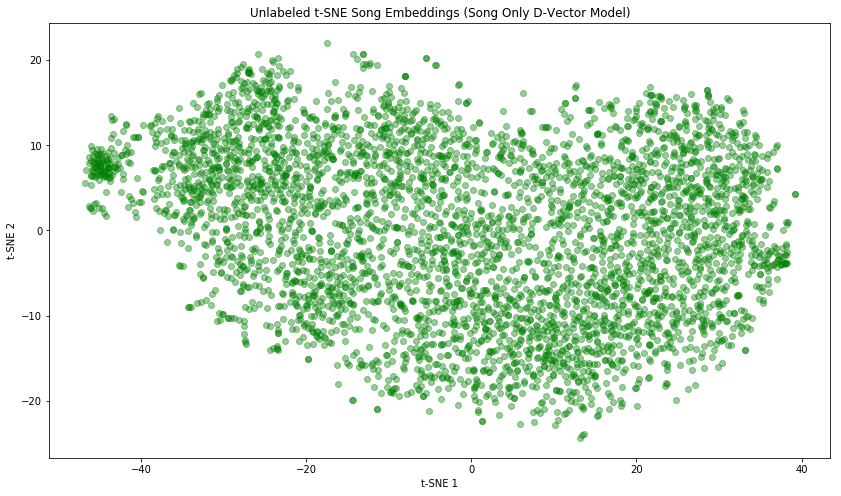

In [103]:
f = plt.figure(figsize=(14,8))
plt.title('Unlabeled t-SNE Song Embeddings (Song Only D-Vector Model)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.scatter(x_emb[:, 0], x_emb[:, 1], alpha=0.4, c='g')
plt.show()

#### Genre Labled t-SNE Song Model Plot

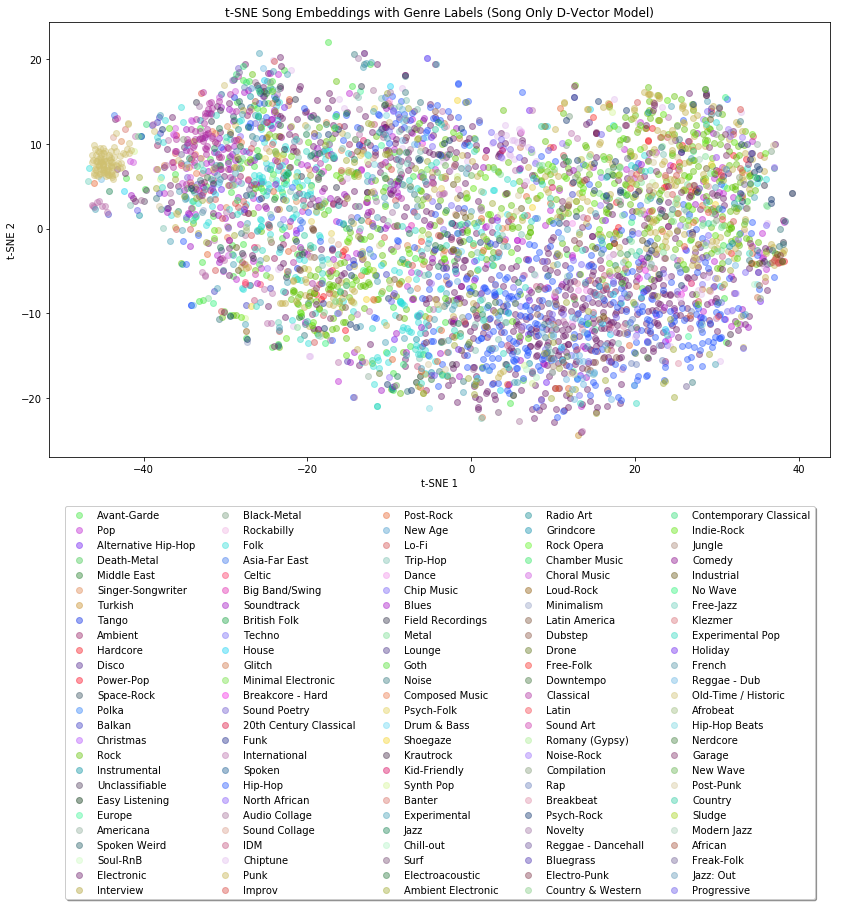

In [104]:
genre_df = pd.read_csv('../fma_metadata/genres.csv')

f = plt.figure(figsize=(14,8))
plt.title('t-SNE Song Embeddings with Genre Labels (Song Only D-Vector Model)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
for gen_id, genre_type in zip(genre_num_ids, genre_spec_ids):
    genre_name = genre_df.loc[genre_df['genre_id'] == int(gen_id), 'title'].values
    genre_name = genre_name[0]
    if genre_type.shape[0] > 0:
        plt.scatter(x_emb[genre_type, 0], x_emb[genre_type, 1], alpha=0.4, label=genre_name, \
                c=np.random.rand(1,3))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)
plt.show()

### Average Song Embeddings (Genre based D-Vector Model)
For each song, an average embedding is calculated by averaging each D-Vector extracted from 240ms overlapping windows for each clip. The D-Vector model comes from the work "Generalized End-to-End Loss for Speaker Verification" by Wan et al. An open source implementation of this project (https://github.com/HarryVolek/PyTorch_Speaker_Verification) was slightly modified to generate the embeddings for each song. Prior to training, the spectrogram is calculated for each song, then partitioned into a three dimensional array where each sample contains 160 frames (1.6 seconds) and 40 coefficients. If an interval is less than 160 frames, then it is not appended to the final song spectrogram. 

The Genre based D-Vector Model differs from the song-based model in that every spectrogram from the same genre is combined into a single spectrogram for that genre. During training, a selection of samples are chosen from the genre spectrogram to update the model parameters. The motivation behind this approach is to reduce the cosine distance between samples of the same genre and samples of different gernes. One assumes that songs of the same genre share similar characteristics, therefore they should be near each other in feature space. 

In [105]:
song_embs, song_ids = get_embeddings_and_ids('avg_genre_song_embeddings/')
genre_num_ids, genre_spec_ids = ordered_genres_and_ids(song_ids, ids_genre_df)

In [106]:
x_emb = TSNE(
    n_components=2, 
    perplexity=100, 
    n_iter=1000, 
    early_exaggeration=12.0, 
    metric='cosine',
).fit_transform(song_embs)

#### Unlabeled t-SNE Song Model Plot

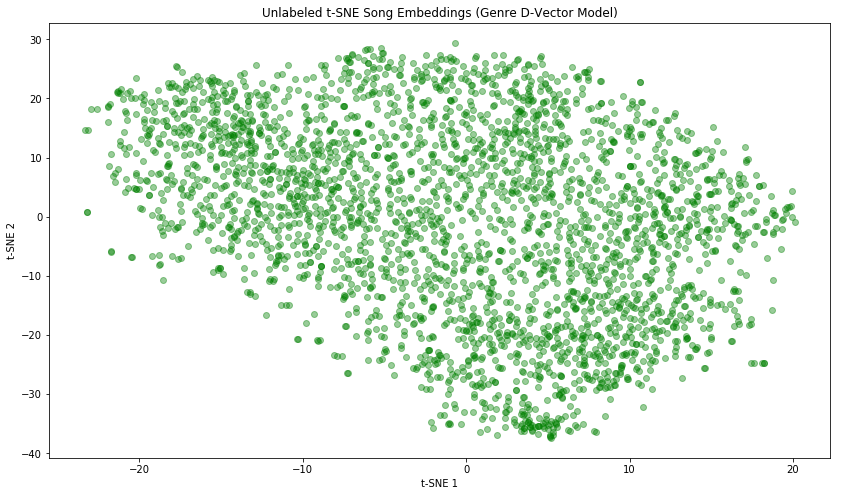

In [107]:
f = plt.figure(figsize=(14,8))
plt.title('Unlabeled t-SNE Song Embeddings (Genre D-Vector Model)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.scatter(x_emb[:, 0], x_emb[:, 1], alpha=0.4, c='g')
plt.show()

#### Genre Labeled t-SNE Genre Model Plot

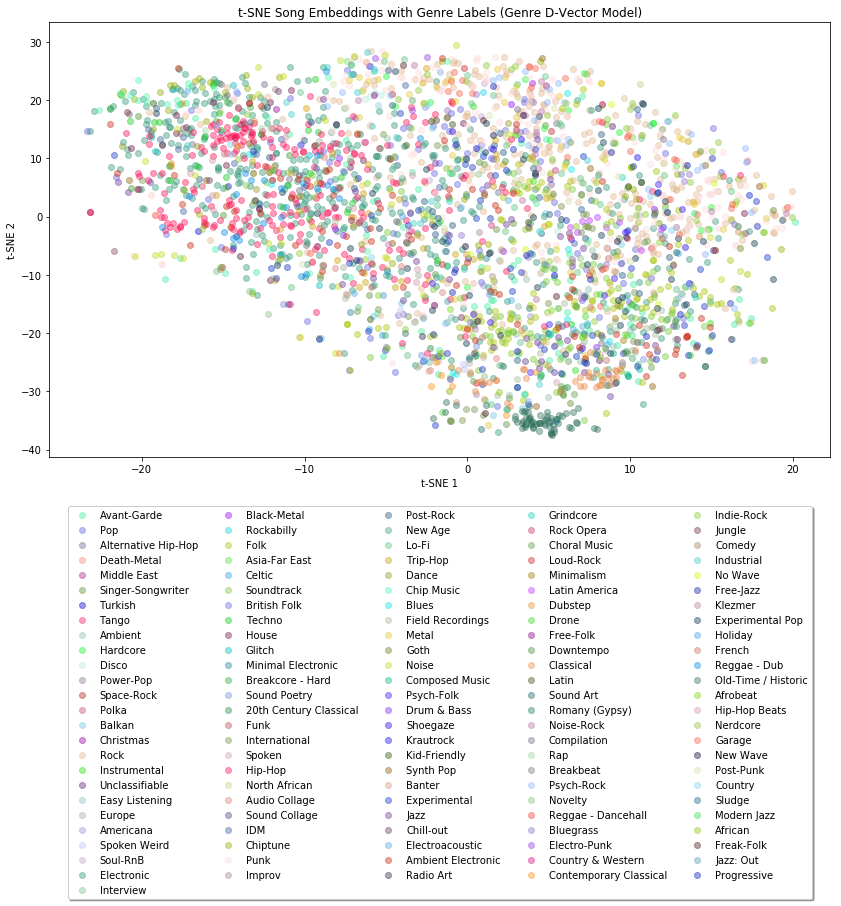

In [108]:
genre_df = pd.read_csv('../fma_metadata/genres.csv')

f = plt.figure(figsize=(14,8))
plt.title('t-SNE Song Embeddings with Genre Labels (Genre D-Vector Model)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
for gen_id, genre_type in zip(genre_num_ids, genre_spec_ids):
    genre_name = genre_df.loc[genre_df['genre_id'] == int(gen_id), 'title'].values
    genre_name = genre_name[0]
    if genre_type.shape[0] > 0:
        plt.scatter(x_emb[genre_type, 0], x_emb[genre_type, 1], alpha=0.4, label=genre_name, \
                c=np.random.rand(1,3))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)
plt.show()